# Анализ А/В теста. Сравнение гипотез  

Мы — аналитики крупного интернет-магазина. Вместе с отделом маркетинга мы подготовили список гипотез для увеличения выручки.
Необходимо приоритизировать гипотезы, запустить A/B-тест и проанализировать результаты.

## Предварительный осмотр данных 

In [1]:
#импортируем необходимые библиотеки 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
import math
import numpy as np

**Описание данных**

Файл /datasets/hypothesis.csv:
- `Hypothesis` — краткое описание гипотезы;
- `Reach` — охват пользователей по 10-балльной шкале;
- `Impact` — влияние на пользователей по 10-балльной шкале;
- `Confidence` — уверенность в гипотезе по 10-балльной шкале;
- `Efforts` — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

Файл /datasets/orders.csv:
- `transactionId` — идентификатор заказа;
- `visitorId` — идентификатор пользователя, совершившего заказ;
- `date` — дата, когда был совершён заказ;
- `revenue` — выручка заказа;
- `group` — группа A/B-теста, в которую попал заказ.

Файл /datasets/visitors.csv:
- `date` — дата;
- `group` — группа A/B-теста;
- `visitors` — количество пользователей в указанную дату в указанной группе A/B-теста

In [2]:
#загрузим данные 
hypothesis = pd.read_csv('/datasets/hypothesis.csv')
orders = pd.read_csv('/datasets/orders.csv')
visitors = pd.read_csv('/datasets/visitors.csv')

In [3]:
display(hypothesis,hypothesis.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3
6,Показать на главной странице баннеры с актуаль...,5,3,8,3
7,Добавить форму подписки на все основные страни...,10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5


None

Выводы:
- 9 различных гипотез. У каждой по 4ём критериям оценки от 1 до 10. Здесь всё хорошо 
- некорректные названия столбцов (заглавные буквы)
- пропусков нет, дубликатов нет, типы данных корректны 

In [4]:
display(orders,orders.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
...,...,...,...,...,...
1192,2662137336,3733762160,2019-08-14,6490,B
1193,2203539145,370388673,2019-08-14,3190,A
1194,1807773912,573423106,2019-08-14,10550,A
1195,1947021204,1614305549,2019-08-14,100,A


None

Выводы:
- некорректные названия столбцов
- некорреткный тип данных у столбца `date`
- пропусков нет
- проверить на дубликаты (полные и неочевидные)

In [5]:
display(visitors,visitors.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
...,...,...,...
57,2019-08-27,B,720
58,2019-08-28,B,654
59,2019-08-29,B,531
60,2019-08-30,B,490


None

Выводы:
- некорректный тип данных столбца `date`
- пропусков нет
- проверить на дубликаты( полные и неочевидные)

## Предобработка данных

In [6]:
#переименуем столбцы в таблицах
hypothesis.columns = ['hypothesis','reach','impact','confidence', 'efforts']
orders.columns = ['transaction_id','visitor_id', 'date','revenue','group']

In [7]:
#приведём столбцы с датами к корректному типу данных 
orders['date'] = pd.to_datetime(orders['date'])
visitors['date'] = pd.to_datetime(visitors['date'])

In [8]:
#проверим на неочевидные дубликаты по группам А/В теста 
display(orders['group'].unique(),visitors['group'].unique())

array(['B', 'A'], dtype=object)

array(['A', 'B'], dtype=object)

Посчитаем количество уникальных пользоваталей в нашей A/B тесте 

In [9]:
len(orders['visitor_id'].unique())

1031

А теперь посчитаем по группам:

In [10]:
group_A = orders.query('group == "A"')
len(group_A['visitor_id'].unique())

503

In [11]:
group_B = orders.query('group == "B"')
len(group_B['visitor_id'].unique())

586

Вот и проблема. В общей таблице у нас 1031 уникальных пользоваталей. А при разделении на группы 503+586 = 1089. То есть есть 58 пользователей(1089-1031), которые попали в обе группы. Найдем их 

In [12]:
union = group_A.merge(group_B,on = 'visitor_id')
len(union['visitor_id'].unique())

58

Нашли.Что с ними делать? Мы не знаем, в какую группу они должны были попасть. Чтобы не угадывать - просто удалим этих пользователей из первоначальной таблицы

In [13]:
visitor_both_group = union['visitor_id'].to_list()
orders = orders[~orders['visitor_id'].isin(visitor_both_group)]
len(orders['visitor_id'].unique())

973

Было 1031 уникальный, осталось 973. Удалили 58 пользоваталей, которые попали в обе группы 

Теперь посмотрим сопадение дат по orders и visitors

In [14]:
orders

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B
...,...,...,...,...,...
1191,3592955527,608641596,2019-08-14,16490,B
1192,2662137336,3733762160,2019-08-14,6490,B
1193,2203539145,370388673,2019-08-14,3190,A
1194,1807773912,573423106,2019-08-14,10550,A


In [15]:
display(orders['date'].min(),orders['date'].max())
display(visitors['date'].min(),visitors['date'].max())

Timestamp('2019-08-01 00:00:00')

Timestamp('2019-08-31 00:00:00')

Timestamp('2019-08-01 00:00:00')

Timestamp('2019-08-31 00:00:00')

Даты совпадают 

In [16]:
#проверим все таблицы на полные дубликаты 
display(hypothesis.duplicated().sum(),orders.duplicated().sum(),visitors.duplicated().sum())

0

0

0

In [17]:
#проверим изменения
display( hypothesis.head(),orders.head(),visitors.head())

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1


,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


Можно переходить к анализу данных

## Приоритезация гипотез

### ICE

In [18]:
hypothesis['ice'] = hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']

In [19]:
with pd.option_context('display.max_colwidth', 120):
    display(hypothesis.sort_values('ice', ascending=False))

,hypothesis,reach,impact,confidence,efforts,ice
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.200000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.333333
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.200000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.333333
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.125000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.000000


В первой тройке по `ice` гипотезы №8,№0,№7

### RICE

In [20]:
hypothesis['rice'] = hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence'] / \
                    hypothesis['efforts']

In [21]:
hypothesis.sort_values('rice', ascending=False)

,hypothesis,reach,impact,confidence,efforts,ice,rice
7,Добавить форму подписки на все основные страни...,10,7,8,5,11.200000,112.0
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3,7.000000,56.0
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6,13.333333,40.0
6,Показать на главной странице баннеры с актуаль...,5,3,8,3,8.000000,40.0
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5,16.200000,16.2
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8,1.125000,9.0
1,"Запустить собственную службу доставки, что сок...",2,5,4,10,2.000000,4.0
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3,1.333333,4.0
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1,1.000000,3.0


При применении `rice` оценки приоритизации гипотез на первое место вышла гипотеза №7. Всё дело в параметре `reach` (или охвате пользователей), который не учитывался при расчете `ice`. \
У гипотезы №7 и №2 этот параметр имеет оценки 10 и 8 соответственно,а гипотеза №8 откатилась на пятое место, потому что у неё `reach` - 1.

## Анализ результатов A/B теста 

Подготовим таблицу для анализа результатов A/B теста. Посчитаем средний чек и конверсию по группам/по дням

In [22]:
orders_grouped = (orders.groupby(['date','group'], as_index=False)
                        .agg({'transaction_id':'nunique','visitor_id':'nunique','revenue':'sum'}))\
                        .rename(columns={'transaction_id':'orders','visitor_id':'buyers'})
orders_grouped['group_copy'] = orders_grouped['group']
orders_grouped = orders_grouped.set_index(['date','group'])
orders_cumsum = orders_grouped.sort_values(['date','group']).groupby('group_copy').cumsum().reset_index()

In [23]:
orders_grouped

orders  buyers  revenue group_copy
date       group                                    
2019-08-01 A          23      19   142779          A
           B          17      17    59758          B
2019-08-02 A          19      18    91602          A
           B          23      22   162043          B
2019-08-03 A          24      24   112473          A
...                  ...     ...      ...        ...
2019-08-29 B          15      15   106100          B
2019-08-30 A           9       8    78180          A
           B          21      21   209223          B
2019-08-31 A           8       8    53243          A
           B          17      17   113139          B

[62 rows x 4 columns]

In [24]:
# посчитаем сумму визитов по дням в каждой группе
visitors_cumsum = visitors.groupby(['date','group'], as_index=False).agg({'visitors':'sum'}).sort_values(['date','group'])
# скопируем group чтобы провести по ней кумулятивную сумму
visitors_cumsum['group_copy'] = visitors_cumsum['group']
visitors_cumsum = visitors_cumsum.set_index(['date','group']).groupby('group_copy').cumsum().reset_index()    

In [25]:
cummulative = orders_cumsum.join(visitors_cumsum[['visitors']])

In [26]:
#считаем средний чек и конверсию 
cummulative['average_check'] = cummulative['revenue'] / cummulative['orders']
cummulative['conversion'] = cummulative['orders'] / cummulative['visitors']

In [27]:
cummulative.head()

,date,group,orders,buyers,revenue,visitors,average_check,conversion
0,2019-08-01,A,23,19,142779,719,6207.782609,0.031989
1,2019-08-01,B,17,17,59758,713,3515.176471,0.023843
2,2019-08-02,A,42,37,234381,1338,5580.500000,0.031390
3,2019-08-02,B,40,39,221801,1294,5545.025000,0.030912
4,2019-08-03,A,66,61,346854,1845,5255.363636,0.035772


Посчитали кумулятивные данные по группам и дням( количество заказов, покупателей, выручку, посетителей). А так же средний чек и конверсию

### График кумулятивной выручки по группам

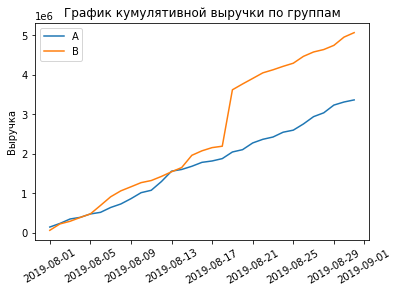

In [28]:
cummulativeA = cummulative[cummulative['group']=='A'][['date', 'revenue']]
cummulativeB = cummulative[cummulative['group']=='B'][['date', 'revenue']]
plt.plot(cummulativeA.iloc[:,0].to_frame(), cummulativeA.iloc[:,1].to_frame(), label='A' )
plt.plot(cummulativeB.iloc[:,0].to_frame(), cummulativeB.iloc[:,1].to_frame(), label='B')
plt.title('График кумулятивной выручки по группам')
plt.ylabel("Выручка")
plt.xticks(rotation=30)
plt.legend()
plt.show()

**Выводы**:
- У группы B наблюдается скачок по выручке. Этот скачок обусловлен крупной выручкой в этот день( крупным чеком)
- В целом графики растут линейно и разница по итогу обусловлена скачком в середине временного отрезка анализа

### График кумулятивного среднего чека по группам

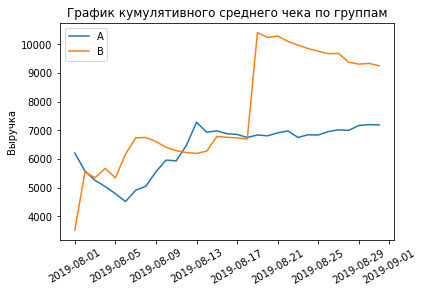

In [29]:
cummulativeA = cummulative[cummulative['group']=='A'][['date', 'average_check']]
cummulativeB = cummulative[cummulative['group']=='B'][['date', 'average_check']]
plt.plot(cummulativeA.iloc[:,0].to_frame(), cummulativeA.iloc[:,1].to_frame(), label='A' )
plt.plot(cummulativeB.iloc[:,0].to_frame(), cummulativeB.iloc[:,1].to_frame(), label='B')
plt.title('График кумулятивного среднего чека по группам')
plt.ylabel("Выручка")
plt.xticks(rotation=30)
plt.legend()
plt.show()

**Выводы**: 
- в тот же самый момент у группы B резкий скачок по кумулятивному среднему чеку

### График относительного изменения кумулятивного среднего чека группы B к группе A

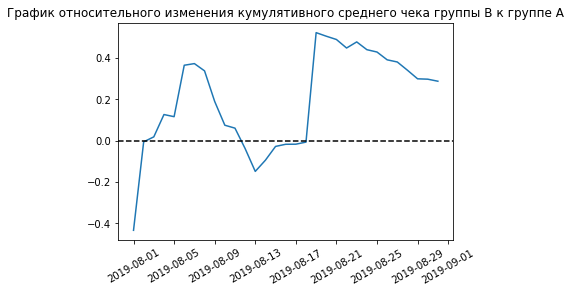

In [30]:
temp = (cummulativeA[['date', 'average_check']].merge(cummulativeB[['date', 'average_check']], 
                                            left_on='date', right_on='date', how='left', suffixes=['_A', '_B']))
plt.plot(temp['date'], temp['average_check_B'] / temp['average_check_A']-1)
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A')
plt.axhline(y=0, color='black', linestyle='--')
plt.xticks(rotation=30)
plt.show()

**Вывод**:
- по сути все графики иллюстируют одну и ту же картину. Средний чек по группе B выше, чем по группе A

### График кумулятивной конверсии по группам

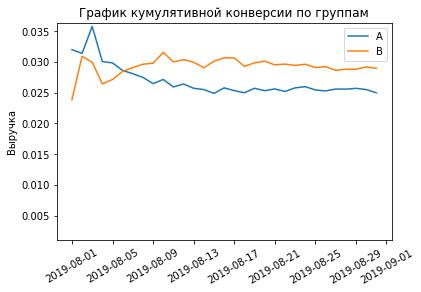

In [31]:
cummulativeA = cummulative[cummulative['group']=='A'][['date', 'conversion']]
cummulativeB = cummulative[cummulative['group']=='B'][['date', 'conversion']]
plt.plot(cummulativeA.iloc[:,0].to_frame(), cummulativeA.iloc[:,1].to_frame(), label='A' )
plt.plot(cummulativeB.iloc[:,0].to_frame(), cummulativeB.iloc[:,1].to_frame(), label='B')
plt.title('График кумулятивной конверсии по группам')
plt.ylabel("Выручка")
plt.ylim(0.001)
plt.xticks(rotation=30)
plt.legend()
plt.show()

**Вывод**:
- Конверсия группы A выглядит хуже,чем у группы B

### График относительного изменения кумулятивной конверсии группы B к группе A

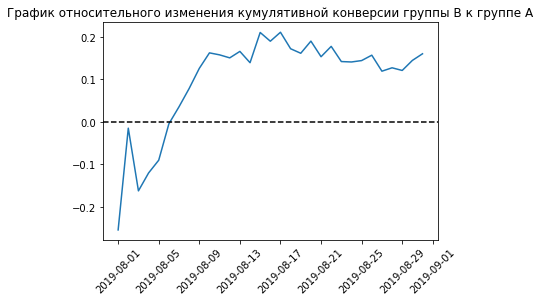

In [32]:
temp = (cummulativeA[['date', 'conversion']].merge(cummulativeB[['date', 'conversion']], 
                                            left_on='date', right_on='date', how='left', suffixes=['_A', '_B']))
plt.plot(temp['date'], temp['conversion_B'] / temp['conversion_A']-1)
plt.title('График относительного изменения кумулятивной конверсии группы B к группе A')
plt.axhline(y=0, color='black', linestyle='--')
plt.xticks(rotation=45)
plt.show()

**Вывод**:
- Конверсия группы B всё так же выглядит лучше 

### График количества заказов по пользователям

In [33]:
#создадим таблицу по количеству заказов каждого пользователя 
orders_per_user = orders.groupby('visitor_id', as_index=False).agg({'transaction_id':'nunique'})\
                         .rename(columns={'transaction_id':'orders'})
orders_per_user.head()

,visitor_id,orders
0,5114589,1
1,6958315,1
2,11685486,1
3,39475350,1
4,47206413,1


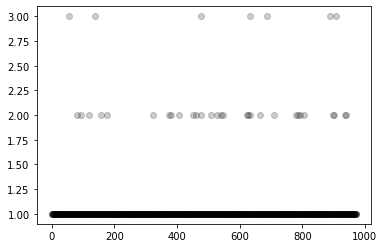

In [34]:
x_values = pd.Series(range(0,len(orders_per_user['orders'])))
plt.scatter(x_values, orders_per_user['orders'], color='black', alpha = 0.2)
plt.show()

**Вывод**:
- Основная часть клиентов делает 1 заказ. Немало клиентов делает и по 2 заказа

###  95-й и 99-й перцентили количества заказов на пользователя. Выберем границу для определения аномальных пользователей

In [35]:
print('95 перцентиль: %.2f' % (np.percentile(orders_per_user['orders'], [95])))
print('99 перцентиль: %.2f' % (np.percentile(orders_per_user['orders'], [99])))

95 перцентиль: 1.00
99 перцентиль: 2.00


**Вывод**:
- 99 процентов пользователей делают от 1 до 2 заказов. Выберем **границу аномальности**: 3 заказов и более

In [36]:
#введем список без аномальных заказов
normal_orders = orders_per_user[orders_per_user['orders'] >= 3]['visitor_id'].to_list()

### График стоимостей заказов

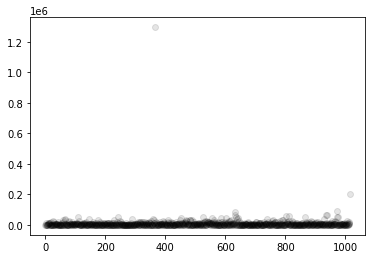

In [37]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'], color='black',alpha = 0.1)
plt.show()

**Вывод**: Заметны 2 аномальных значения. Но одно их них явно выделяется. Скорее всего это именно тот заказ, который вызывал скачки на графиках кумулятивной суммы и средней чека

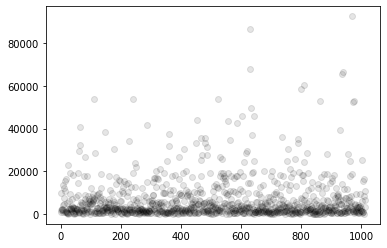

In [38]:
#отфильтруем и построим график без двух очень крупных выбросов
orders_without_big_check = orders.query('revenue < 200000')
x_values = pd.Series(range(0,len(orders_without_big_check['revenue'])))
plt.scatter(x_values, orders_without_big_check['revenue'], color='black',alpha = 0.1)
plt.show()

Можем сказать,что среди остальные заказов так же есть несколько крупных выделяющихся (более 60000)

### 95-й и 99-й перцентили стоимости заказов

In [39]:
print('95 перцентиль: %.2f' % (np.percentile(orders['revenue'], [95])))
print('99 перцентиль: %.2f' % (np.percentile(orders['revenue'], [99])))

95 перцентиль: 26785.00
99 перцентиль: 53904.00


**Вывод**: Будем считать аномальными заказы на сумму 53904 у.е. и более

In [40]:
#добавим в наш отфильтрованный список так же фильтрацию по стоимости заказа
normal_orders = orders_per_user[orders_per_user['orders'] >= 3]['visitor_id'].to_list()
normal_orders

[249864742,
 611059232,
 2108163459,
 2742574263,
 2988190573,
 3908431265,
 3967698036]

### Cтатистическая значимость различий в конверсии между группами по «сырым» данным

In [41]:
conversion = (orders.groupby('group').agg({'transaction_id':'count'}).rename(columns={'transaction_id':'orders'}))\
                                     .join((visitors.groupby('group').agg({'visitors':'sum'}))).reset_index()
conversion['conversion'] = conversion['orders'] / conversion['visitors']

In [42]:
conversion

,group,orders,visitors,conversion
0,A,468,18736,0.024979
1,B,548,18916,0.028970


Сформулируем 2 стат.гипотезы: 
- H0: Конверсия в группе A статистически НЕ ОТЛИЧАЕТСЯ от  конверсии в группе B
- Н1: Конверсия в группе A статистически ОТЛИЧАЕТСЯ от  конверсии в группе B

In [43]:
alpha=0.05
purchases = np.array(conversion['orders'])
leads = np.array(conversion['visitors'])
p1 = purchases[0] / leads[0]
p2 = purchases[1] / leads[1]
combined = (purchases[0] + purchases[1]) / (leads[0] + leads[1])
difference = p1-p2
z_value = difference / math.sqrt(combined * (1 - combined) * (1 / leads[0] + 1 / leads[1]))
distr = st.norm(0,1)
p_value = (1 - distr.cdf(abs(z_value))) * 2
print('p-значение: ', p_value)
if (p_value < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  0.016851380434703023
Отвергаем нулевую гипотезу


**Вывод**: 
- По сырым данным конверсия в группе B выше, чем в группе А.

In [45]:
#разобьем по группам A и B
ordersByVisitorA = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': "nunique"})\
    ['transaction_id']
)

ordersByVisitorB = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': "nunique"})\
    ['transaction_id']
)


sampleA = pd.concat((ordersByVisitorA,pd.Series([0] * (visitors[visitors['group'] == 'A'].visitors.sum() - ordersByVisitorA.shape[0]))))\
  .value_counts()

sampleB = pd.concat((ordersByVisitorB,pd.Series([0] * (visitors[visitors['group'] == 'B'].visitors.sum() - ordersByVisitorB.shape[0]))))\
  .value_counts()


#проверим 
display(sampleA, sampleB)
 

0    18291
1      427
2       13
3        5
dtype: int64

0    18388
1      510
2       16
3        2
dtype: int64

In [46]:
# проведём тест 
print("{0:.3f}".format(st.mannwhitneyu(sampleA, sampleB)[1]))

print("{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

0.886
0.010


Вывод: По «сырым» данным различий в среднем числе заказов групп A и B нет.
Первое число — p-value = 0.886 больше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в среднем числе заказов между группами нет, не отвергаем. Относительный проигрыш группы A минимален и равен 1% — второе число в выводе.

### Cтатистическая значимость различий в среднем чеке заказа между группами по «сырым» данным

Так как в наших данных по средним чекам есть большие выбросы, воспользуемся критерием Манна - Уитни

Сформулируем 2 стат.гипотезы: 
- H0: Средний чек  в группе A статистически НЕ ОТЛИЧАЕТСЯ от  среднего чека  в группе B
- Н1: Средний чек  в группе A статистически ОТЛИЧАЕТСЯ от среднего чека в группе B

In [47]:
alpha = 0.05
results = st.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])
pvalue = results.pvalue
print('p-значение: ', pvalue)
if (pvalue < alpha):
    print("Отвергаем H0: разница статистически значима")
else:
    print("Не получилось отвергнуть H0: вывод о различии сделать нельзя")

p-значение:  0.8294908998149533
Не получилось отвергнуть H0: вывод о различии сделать нельзя


### Cтатистическая значимость различий в конверсии между группами по «очищенным» данным

Введем наш отфильтрованную таблицу orders. Мы принял, то что считаем аномальными 3 и более заказов, и заказы на сумму выше 53904

In [48]:
#отфильтровали по количетсву заказов 
clear_orders = orders[~orders['visitor_id'].isin(normal_orders)]
#отфильтровали по сумме заказа
clear_orders = clear_orders.query('revenue < 53904')

In [49]:
conversion_clear = (clear_orders.groupby('group').agg({'transaction_id':'count'}).rename(columns={'transaction_id':'orders'}))\
                                                .join((visitors.groupby('group').agg({'visitors':'sum'}))).reset_index()

Сформулируем 2 стат.гипотезы: 
- H0: Конверсия в группе A статистически НЕ ОТЛИЧАЕТСЯ от  конверсии в группе B
- Н1: Конверсия в группе A статистически ОТЛИЧАЕТСЯ от  конверсии в группе B

In [50]:
alpha=0.05
purchases = np.array(conversion_clear['orders'])
leads = np.array(conversion_clear['visitors'])
p1 = purchases[0] / leads[0]
p2 = purchases[1] / leads[1]
combined = (purchases[0] + purchases[1]) / (leads[0] + leads[1])
difference = p1-p2
z_value = difference / math.sqrt(combined * (1 - combined) * (1 / leads[0] + 1 / leads[1]))
distr = st.norm(0,1)
p_value = (1 - distr.cdf(abs(z_value))) * 2
print('p-значение: ', p_value)
if (p_value < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  0.005283098862493896
Отвергаем нулевую гипотезу


**Вывод**: 
- Даже по очищенным данным конверсия в группе B превышает ковнверсию в группу А

Повторим наш код из пункта 4.10, только уже с очищенными данными 

In [51]:
#разобьем по группам A и B
ordersByVisitorA = (
    clear_orders[clear_orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': "nunique"})\
    ['transaction_id']
)

ordersByVisitorB = (
    clear_orders[clear_orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': "nunique"})\
    ['transaction_id']
)


sampleA = pd.concat((ordersByVisitorA,pd.Series([0] * (visitors[visitors['group'] == 'A'].visitors.sum() - ordersByVisitorA.shape[0]))))\
  .value_counts()

sampleB = pd.concat((ordersByVisitorB,pd.Series([0] * (visitors[visitors['group'] == 'B'].visitors.sum() - ordersByVisitorB.shape[0]))))\
  .value_counts()

# проведём тест 
print("{0:.3f}".format(st.mannwhitneyu(sampleA, sampleB)[1]))

print("{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

0.700
0.010


Вывод: По «очищенным» данным различий в среднем числе заказов групп A и B так же нет.
Первое число — p-value = 0.7 больше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в среднем числе заказов между группами нет, не отвергаем. Относительный проигрыш группы A минимален и равен 1% — второе число в выводе.

### Cтатистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным

Сформулируем 2 стат.гипотезы: 
- H0: Средний чек  в группе A статистически НЕ ОТЛИЧАЕТСЯ от  среднего чека  в группе B
- Н1: Средний чек  в группе A статистически ОТЛИЧАЕТСЯ от среднего чека в группе B

In [52]:
alpha = 0.05
results = st.mannwhitneyu(clear_orders[clear_orders['group']=='A']['revenue'], clear_orders[clear_orders['group']=='B']['revenue'])
pvalue = results.pvalue
print('p-значение: ', pvalue)
if (pvalue < alpha):
    print("Отвергаем H0: разница статистически значима")
else:
    print("Не получилось отвергнуть H0: вывод о различии сделать нельзя")

p-значение:  0.8417126416851524
Не получилось отвергнуть H0: вывод о различии сделать нельзя


### Графики кумулятивной конверсии и среднего чека по очищенным данным

Просто повторим шаги 4.2 и 4.4 только для очищенных данных

In [53]:
clear_orders_grouped = (clear_orders.groupby(['date','group'], as_index=False)
                        .agg({'transaction_id':'nunique','visitor_id':'nunique','revenue':'sum'}))\
                        .rename(columns={'transaction_id':'orders','visitor_id':'buyers'})
clear_orders_grouped['group_copy'] = clear_orders_grouped['group']
clear_orders_grouped = clear_orders_grouped.set_index(['date','group'])
orders_cumsum = clear_orders_grouped.sort_values(['date','group']).groupby('group_copy').cumsum().reset_index()

In [54]:
# посчитаем сумму визитов по дням в каждой группе
visitors_cumsum = visitors.groupby(['date','group'], as_index=False).agg({'visitors':'sum'}).sort_values(['date','group'])
# скопируем group чтобы провести по ней кумулятивную сумму
visitors_cumsum['group_copy'] = visitors_cumsum['group']
visitors_cumsum = visitors_cumsum.set_index(['date','group']).groupby('group_copy').cumsum().reset_index()  

In [55]:
cummulative = orders_cumsum.join(visitors_cumsum[['visitors']])

In [56]:
cummulative['average_check'] = cummulative['revenue'] / cummulative['orders']
cummulative['conversion'] = cummulative['orders'] / cummulative['visitors']

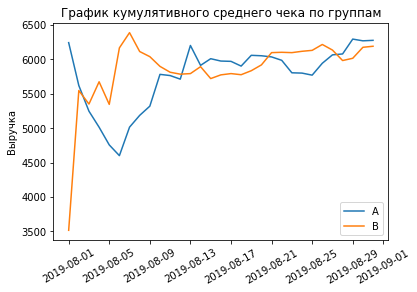

In [57]:
cummulativeA = cummulative[cummulative['group']=='A'][['date', 'average_check']]
cummulativeB = cummulative[cummulative['group']=='B'][['date', 'average_check']]
plt.plot(cummulativeA.iloc[:,0].to_frame(), cummulativeA.iloc[:,1].to_frame(), label='A' )
plt.plot(cummulativeB.iloc[:,0].to_frame(), cummulativeB.iloc[:,1].to_frame(), label='B')
plt.title('График кумулятивного среднего чека по группам')
plt.ylabel("Выручка")
plt.xticks(rotation=30)
plt.legend()
plt.show()

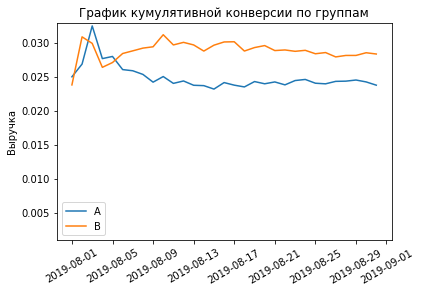

In [58]:
cummulativeA = cummulative[cummulative['group']=='A'][['date', 'conversion']]
cummulativeB = cummulative[cummulative['group']=='B'][['date', 'conversion']]
plt.plot(cummulativeA.iloc[:,0].to_frame(), cummulativeA.iloc[:,1].to_frame(), label='A' )
plt.plot(cummulativeB.iloc[:,0].to_frame(), cummulativeB.iloc[:,1].to_frame(), label='B')
plt.title('График кумулятивной конверсии по группам')
plt.ylabel("Выручка")
plt.ylim(0.001)
plt.xticks(rotation=30)
plt.legend()
plt.show()

## Вывод и решение по результатам теста

Выводы:
- График кумулятивной конверсии стабилизировался и при проверке гипотез ( и по сырым, и по очищенным данным) мы можем говорить, что конверсия в группе B лучше, чем в группе A
- График среднего чек не стабилизировался. График кумулятивного среднего чека по очищенным данным показывает, что график скачет и каждый день группа A и группа B меняются местами
- И по "сырым" и по "очищенным" данным различий в среднем числе заказов групп A и B нет
- И по "сырым" и по "очищенным" данным различий в среднем чеке заказов групп A и B нет
- Примем решение завершить тест и зафиксировать ,что "группа В показала себя лучше". Ведь при отсутствии статистической разницы между средним чеком у группы В будет бОльшая выручка, так как конверчия выше, чем в группе А. 